<a href="https://colab.research.google.com/github/supriyag123/PHD_Pub/blob/main/AGENTIC-MODULE2-VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Found existing trained VAE models. Loading...
VAE models loaded successfully!
Skipping training plots since VAE was loaded from existing models
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['decoder']
Received: inputs=Tensor(shape=(2902, 5))
  warnings.warn(msg)


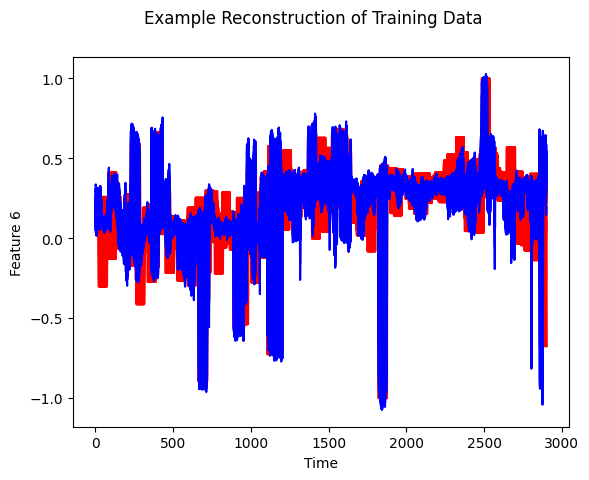

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['decoder']
Received: inputs=Tensor(shape=(725, 5))
  warnings.warn(msg)


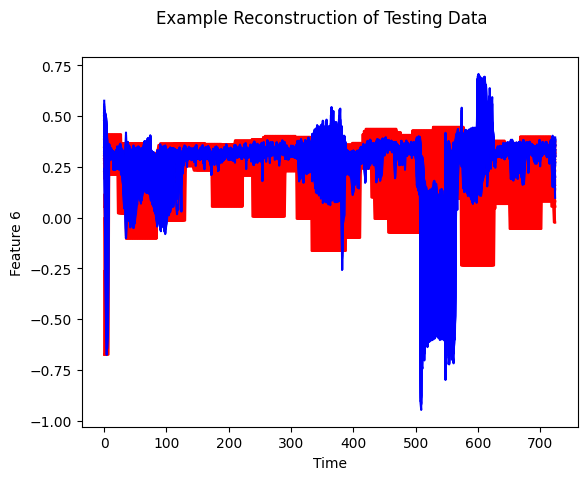

Found existing generated data. Loading...
Loaded generated data with shape: (362700, 600)
Found existing VAR analysis results. Loading...
Loaded final results - X: (362700, 600), Y: (362700,)
VAE training complete. Generated data and window labels saved.


NameError: name 'x' is not defined

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import math
import plotly.graph_objects as go
import keras
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed, Input
from keras.models import Model
from keras import saving
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import Callback
import plotly
from keras import losses
import plotly.express as px

# Load data
train_data = np.load(r'/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/multivariate_long_sequences-TRAIN-Daily-DIRECT-VAR.npy')
window_label = np.load(r'/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/multivariate_long_sequences_WINDOW-Daily-DIRECT-VAR.npy')

n_seq = train_data.shape[0]
window_size = train_data.shape[1]
n_features = train_data.shape[2]

maxval = train_data.shape[0]
count_train = int(math.ceil(0.8*maxval))
x_train = train_data[:count_train]
x_test = train_data[count_train:]

# Always define the custom Sampling layer (needed for loading existing models)
saving.get_custom_objects().clear()

@saving.register_keras_serializable(package="MyLayers")
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, factor):
        super().__init__()
        self.factor = factor

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def get_config(self):
        return {"factor": self.factor}

# Check if trained VAE models already exist
encoder_path = r'/content/drive/MyDrive/PHD/2025/VAE_SIMULATION/METROPM_vae-encoder-latent5-dim256.keras'
decoder_path = r'/content/drive/MyDrive/PHD/2025/VAE_SIMULATION/METROPM_vae-decoder-latent5-dim256.keras'

if os.path.exists(encoder_path) and os.path.exists(decoder_path):
    print("Found existing trained VAE models. Loading...")
    encoder = keras.models.load_model(encoder_path)
    decoder = keras.models.load_model(decoder_path)
    print("VAE models loaded successfully!")
    history = None  # No training history since we didn't train

else:
    print("No existing VAE models found. Training new VAE...")

    # Build the encoder
    latent_dim = 5
    intermediate_dim = 256

    # Encoder
    encoder_inputs = layers.Input(shape=(window_size, n_features), name="encoder_input")
    x = layers.LSTM(intermediate_dim, activation='tanh', name="lstm1", return_sequences=True)(encoder_inputs)
    xx = layers.LSTM(int(intermediate_dim/2), activation='tanh', name="lstm2", return_sequences=False)(x)
    x1 = layers.Dense(int(intermediate_dim/2), name="dense")(xx)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x1)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x1)
    z = Sampling(1)([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    encoder.summary()

    # Decoder
    inp_z = Input(shape=(latent_dim,), name="decoder")
    x1 = layers.RepeatVector(window_size, name="repeatvect")(inp_z)
    x2 = layers.Dense(int(intermediate_dim/2), name="Dense2")(x1)
    x22 = layers.LSTM(int(intermediate_dim/2), activation='tanh', return_sequences=True, name="lstm1")(x2)
    x3 = layers.LSTM(intermediate_dim, activation='tanh', return_sequences=True, name="lstm2")(x22)
    decode_out = layers.TimeDistributed(Dense(n_features), name="decodeout")(x3)
    decoder = keras.Model(inp_z, decode_out, name="decoder")
    decoder.summary()

    reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

    # Parameters
    n_epochs = 150
    klstart = 20
    kl_annealtime = n_epochs - klstart
    weight = K.variable(0.0)

    # Define the VAE as a Model with a custom train_step
    class VAE(keras.Model):
        def __init__(self, encoder, decoder, **kwargs):
            super(VAE, self).__init__(**kwargs)
            self.encoder = encoder
            self.decoder = decoder
            self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
            self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
            self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

        @property
        def metrics(self):
            return [
                self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker,
            ]

        def train_step(self, data):
            with tf.GradientTape() as tape:
                z_mean, z_log_var, z = self.encoder(data)
                reconstruction = self.decoder(z)
                reconstruction_loss = tf.reduce_mean(
                    tf.reduce_sum(
                        losses.mean_squared_error(data, reconstruction), axis=-1), keepdims=True
                )

                kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
                kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
                total_loss = reconstruction_loss + (weight * kl_loss)
            grads = tape.gradient(total_loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            self.total_loss_tracker.update_state(total_loss)
            self.reconstruction_loss_tracker.update_state(reconstruction_loss)
            self.kl_loss_tracker.update_state(kl_loss)
            return {
                "loss": self.total_loss_tracker.result(),
                "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result(),
            }

        def test_step(self, data):
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    losses.mean_squared_error(data, reconstruction), axis=-1), keepdims=True
            )

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss

            return {
                "loss": self.total_loss_tracker.result(),
                "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result(),
            }

    # CALLBACKS
    es = keras.callbacks.EarlyStopping(patience=50, verbose=1, min_delta=0.0001, monitor='loss', mode='auto', restore_best_weights=True)

    class AnnealingCallback(Callback):
        def __init__(self, weight):
            self.weight = weight

        def on_epoch_end(self, epoch, logs={}):
            if epoch > klstart and epoch < klstart * 1.2:
                new_weight = min(K.get_value(self.weight) + (1. / kl_annealtime), 1.)
                K.set_value(self.weight, new_weight)
            print("Current KL Weight is " + str(K.get_value(self.weight)))

    # Train the VAE
    vae = VAE(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Adam(clipnorm=1))
    history = vae.fit(x_train,
                      epochs=n_epochs,
                      batch_size=32,
                      validation_split=0.1,
                      callbacks=[AnnealingCallback(weight)])

    # Save models
    encoder.save(encoder_path)
    decoder.save(decoder_path)
    print("VAE training complete and models saved!")

    # Reload models to ensure consistency
    encoder = keras.models.load_model(encoder_path)
    decoder = keras.models.load_model(decoder_path)

# Plot training history (only if we actually trained)
if history is not None:
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['reconstruction_loss'], label='reconstruction_loss')
    plt.plot(history.history['kl_loss'], label='kl_Loss')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 100)
    plt.show()

    # Just Loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Skipping training plots since VAE was loaded from existing models")

# PLOT TRAIN RECONSTRUCTION
X_test_encoded = encoder.predict(x_train)
X_test_predict = decoder(X_test_encoded[2])
plt.suptitle('Example Reconstruction of Training Data')
plt.xlabel('Time', fontsize='10')
plt.ylabel('Feature 6', fontsize='10')
plt.plot(x_train[:, :, 5], "r", label="Actual")
plt.plot(X_test_predict[:, :, 5], "b", label="reconstructed")
plt.show()

# PLOT TEST RECONSTRUCTION
X_test_encoded = encoder.predict(x_test[:, :, :])
X_test_predict = decoder(X_test_encoded[2])
plt.suptitle('Example Reconstruction of Testing Data')
plt.xlabel('Time', fontsize='10')
plt.ylabel('Feature 6', fontsize='10')
plt.plot(x_test[:, :, 5], "r")
plt.plot(X_test_predict[:, :, 5], "b")
plt.show()

# Get the corresponding window labels for test data
window_label_test = window_label[count_train:]  # Get test portion of window_label
fig = px.scatter(None, x=X_test_encoded[2][:, 0], y=X_test_encoded[2][:, 1], opacity=1, color=window_label_test.astype(str))
fig.update_layout(dict(plot_bgcolor='white'))
fig.update_traces(marker=dict(size=2))
fig.show()

# Check if generated data already exists
generated_data_path = r'/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/generated_large_subsquence2_data.npy'

if os.path.exists(generated_data_path):
    print("Found existing generated data. Loading...")
    results1 = np.load(generated_data_path)
    print(f"Loaded generated data with shape: {results1.shape}")
else:
    print("No existing generated data found. Generating new data...")
    # Generate data for MLP
    generator_multiply = 100

    X_train_encoded = encoder.predict(train_data)
    mu, logvar, z = X_train_encoded
    sigma = tf.exp(0.5 * logvar)
    batch = tf.shape(mu)[0]
    dim = tf.shape(mu)[1]
    store = list()

    for i in range(0, batch):
        all_Z_i = tf.random.normal(shape=(generator_multiply, dim), mean=mu[i, :], stddev=sigma[i, :])
        X_train_decoded = decoder.predict(all_Z_i)
        X_train_decoded = X_train_decoded.reshape((X_train_decoded.shape[0], window_size * n_features))
        store.append(X_train_decoded)

    results1 = np.concatenate(store, axis=0)
    np.save(generated_data_path, results1)
    print(f"Generated and saved new data with shape: {results1.shape}")

# Generate window labels using VAR analysis - Dynamic batching with checkpoints
import pickle
import gc

# Check if final VAR analysis results already exist
final_window_labels_path = r'/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/generated-data-true-window2.npy'
final_data_path = r'/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/generated-data2.npy'

if os.path.exists(final_window_labels_path) and os.path.exists(final_data_path):
    print("Found existing VAR analysis results. Loading...")
    y = np.load(final_window_labels_path)
    x_final = np.load(final_data_path)
    print(f"Loaded final results - X: {x_final.shape}, Y: {y.shape}")
    x = results1
else:
    print("No existing VAR analysis results found. Need to run VAR analysis...")

    # Make sure we have the generated data (results1)
    x = results1
    x_3d = x.reshape((x.shape[0], window_size, n_features))
    n_future = 1
    K = window_size

    from statsmodels.tsa.api import VAR
    from sklearn.metrics import mean_squared_error

    def process_with_dynamic_batching(x_3d, batch_size=50000, checkpoint_dir="/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM"):
        checkpoint_file = f"{checkpoint_dir}/var_analysis_progress.pkl"

        # Load previous progress if exists
        if os.path.exists(checkpoint_file):
            with open(checkpoint_file, 'rb') as f:
                start_idx, all_windows = pickle.load(f)
            print(f"Resuming VAR analysis from sample {start_idx}. Already processed: {len(all_windows)} samples")
        else:
            start_idx, all_windows = 0, []
            print("Starting fresh VAR analysis")

        total_samples = x_3d.shape[0]
        print(f"Total samples to process: {total_samples}")

        batch_num = start_idx // batch_size + 1

        for i in range(start_idx, total_samples):
            # Your exact same VAR analysis logic
            rmse_list = []
            for k in range(2, round(K)):
                cur_seq = x_3d[i, :, :]
                df = pd.DataFrame(cur_seq, columns=['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12'])
                df_train, df_test = df[0:-n_future], df[-n_future:]
                model = VAR(df_train)
                try:
                    model_fitted1 = model.fit(k)
                    forecast_input1 = df_train.values[-k:]
                    fc1 = model_fitted1.forecast(y=forecast_input1, steps=n_future)
                    df_forecast1 = pd.DataFrame(fc1, index=df.index[-n_future:], columns=df.columns)
                    mse = mean_squared_error(df_test['V1'], df_forecast1['V1'].values)
                    rmse_list.append(mse)
                except:
                    rmse_list.append(99999)
                    if i % 5000 == 0:  # Reduce print frequency
                        print('VAR could not solve row number', i, k)

            min_index = rmse_list.index(min(rmse_list))
            min_sw = min_index + 2
            all_windows.append(min_sw)

            # Progress reporting and checkpointing
            if (i + 1) % 1000 == 0:
                print(f'Processed {i + 1}/{total_samples} samples. Current SW = {min_sw}')

            # Save checkpoint every 5000 samples
            if (i + 1) % 5000 == 0:
                with open(checkpoint_file, 'wb') as f:
                    pickle.dump((i + 1, all_windows), f)
                print(f"Checkpoint saved at sample {i + 1}")

                # Optional: Clean up memory
                gc.collect()

            # Save batch results (compatible with original format) every batch_size samples
            if (i + 1) % batch_size == 0 or (i + 1) == total_samples:
                batch_start = ((i + 1) - 1) // batch_size * batch_size
                batch_windows = all_windows[batch_start:i + 1]
                batch_data = x[batch_start:i + 1, :]

                np.save(f'{checkpoint_dir}/generated-data-true-window2-BATCH{batch_num}.npy', np.array(batch_windows))
                np.save(f'{checkpoint_dir}/generated-data2-BATCH{batch_num}.npy', batch_data)

                print(f"Batch {batch_num} saved: samples {batch_start} to {i}")
                batch_num += 1

        # Final save
        with open(checkpoint_file, 'wb') as f:
            pickle.dump((total_samples, all_windows), f)

        # Clean up checkpoint file
        if os.path.exists(checkpoint_file):
            os.remove(checkpoint_file)

        return np.array(all_windows)

    # Run the dynamic batching process
    print("Starting VAR analysis with dynamic batching...")
    y = process_with_dynamic_batching(x_3d)

    # Save final combined results
    np.save(final_window_labels_path, y)
    np.save(final_data_path, x[:len(y)])
    print(f"VAR analysis complete. Saved final results - X: {x[:len(y)].shape}, Y: {y.shape}")

print("VAE training complete. Generated data and window labels saved.")
print(f"Generated data shape: {x[:len(y)].shape}")
print(f"Window labels shape: {y.shape}")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')